# Tutorial 5a: Outlier detection and correction

*This tutorial was generated from an IPython notebook.  You can download the notebook [here](t5a_outlier_detection.ipynb).*

Thus far when we have been doing parameter estimation, we have been making the approximation that our likelihoods are Gaussian distributed.  We appeal to the central limit theorem (or, if you go to Pradeep's session this weekend to maximum entropy ideas) to do this.

I think the following quote from [David MacKay's excellent book](http://www.inference.phy.cam.ac.uk/mackay/itila/book.html) is apt.

>The Gaussian distribution is widely used and often asserted to be a very common distribution in the real world, but I am sceptical about this assertion. Yes, unimodal distributions may be common; but a Gaussian is a special, rather extreme, unimodal distribution. It has very light tails: the log- probability-density decreases quadratically. The typical deviation of $x$ from $\mu$ is $\sigma$, but the respective probabilities that $x$ deviates from $\mu$ by more than 2$\sigma$, 3$\sigma$, 4$\sigma$, and 5$\sigma$, are $\small{0.046}$, $\small{0.003}$, $\small{6\times 10^{−5}}$, and $\small{6\times 10^{−7}}$. In my experience, deviations from a mean four or five times greater than the typical deviation may be rare, but not as rare as $\small{6\times 10^{−5}}$! I therefore urge caution in the use of Gaussian distributions: if a variable that is modelled with a Gaussian actually has a heavier-tailed distribution, the rest of the model will contort itself to reduce the deviations of the outliers, like a sheet of paper being crushed by a
rubber band.

With that in mind, we might want to adjust our likelihood to account for outliers.  Otherwise, the outliers can dominate our calculation of our parameter values.  We will use to methods of outlier detection, both outlined in Sivia, though we will not exactly follow his prescription.  In the first method, Sivia's "Cauchy formulation" of section 8.3.3, assumed a Cauchy distribution (which has long tails) in the likelihood.  The second method is a variant on Sivia's "good-and-bad-data model," strongly influenced by example 2 of [this great blog post](http://jakevdp.github.io/blog/2014/06/06/frequentism-and-bayesianism-2-when-results-differ/) from Jake VanderPlas.

Before we begin, we import our favorite modules, as always.

In [2]:
# As usual, import modules
from __future__ import division, absolute_import, \
                                    print_function, unicode_literals

import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
import pandas as pd

import emcee
import beeswarm
import triangle
from brewer2mpl import sequential

# Utilities from JB
import jb_utils as jb

# Necessary to display plots in this IPython notebook
%matplotlib inline    

## A long-tailed likelihood

We will again use the data set from the Reeves, Trisnadi, et al. paper on the Dorsal morphogen gradient.  We will assess if there are any outliers in the data used to generate Fig. 1F of that paper.  As before, the data can be downloaded [here](../protected/data/reeves_et_al.zip).

<img src="images/reeves_fig1F.png">

The wild type cross sections data set and the Venus data set had outliers.

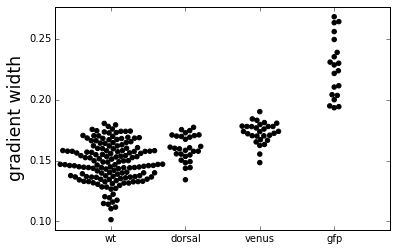

In [3]:
# Load data into DataFrame
file_name = '../data/reeves_et_al/reeves_gradient_width_various_methods.csv'
df = pd.read_csv(file_name, comment='#')

# Rename key columns
df.rename(columns={'wt cross-sections': 'wt', 
                   'anti-Dorsal dl1/+dl-venus/+': 'dorsal',
                   'anti-Venus dl1/+dl-venus/+': 'venus',
                   'anti-GFP  dl1/+dl-GFP/+': 'gfp'}, inplace=True)

# Generate a beeswarm plot
bs_plot, ax = beeswarm.beeswarm(
        [df.wt.dropna(), df.dorsal.dropna(), df.venus.dropna(), 
         df.gfp.dropna()], 
        labels=['wt', 'dorsal', 'venus', 'gfp'])
plt.ylabel('gradient width')

# Adjust axis limits to account for wide wild type plot
plt.xlim((-0.75, 3.75));

According to the box plot, the lowest value for the wild type, and the lowest two values for venus are outliers, that is they are less than 1.5 times the interquartile range from the boundary of the first quartile.  We will use the Cauchy formulation to mitigate their effect on the mean.  (Remember, the median is robust to outliers, so we do not need to worry about that.)

Under the Cauchy formulation, we use the Cauchy distribution as our likelihood.  If our data consist of points $\{x_i, y_i\}$ and our mathematical model for $y$ is $f(x;\mathbf{a})$, where $\mathbf{a}$ are the parameters, the Cauchy likelihood is

\begin{align}
P(D~|~\mathbf{a},\beta,I) = \prod_{i\in D} \left[\pi\beta\left(1 + \left(\frac{x_i - f(x_i;\mathbf{a})}{\beta}\right)^2\right)\right]^{-1}
\end{align}

We then have a posterior of

\begin{align}
P(\mathbf{a},\beta~|~D,I) \propto \left(\prod_{i\in D} \left[\pi\beta\left(1 + \left(\frac{x_i - f(x_i;\mathbf{a})}{\beta}\right)^2\right)\right]^{-1}\right)\,\frac{1}{\beta}\,P(\mathbf{a}~|~I),
\end{align}

since $\beta$ should have a Jeffreys prior.  To get the marginalized posterior, we would have to calculate

\begin{align}
\int_0^\infty \frac{\mathrm{d}\beta}{\beta}\, \prod_{i\in D} \left[\pi\beta\left(1 + \left(\frac{x_i - f(x_i;\mathbf{a})}{\beta}\right)^2\right)\right]^{-1}.
\end{align}

I did it once using contour integration in the complex plane.  It hurt.  But there is an analytical expression.  We will circumvent nasty integration using, you guessed it, MCMC.

### MCMC with a Cauchy prior on Dorsal and Venus data

We now will do MCMC to find the mean gradient widths on the Dorsal and Venus data sets.  In this case, the posterior is

\begin{align}
P(\sigma_\mathrm{Dorsal}, \beta~|~D,I) \propto \frac{1}{\beta}\prod_{i\in D} \left[\pi\beta\left(1 + \left(\frac{x_i - f(x_i;\mathbf{a})}{\beta}\right)^2\right)\right]^{-1},
\end{align}

so

\begin{align}
\ln P(\sigma_\mathrm{Dorsal}, \beta~|~D,I) = \text{constant} - (n+1) \ln \beta
- \sum_{i\in D} \ln\left(1 + \left(\frac{x_i - \sigma_\mathrm{Dorsal}}{\beta}\right)^2\right)
\end{align}

Let's write a function for our log posterior.

In [4]:
# Log posterior with Cauchy likelihood
def log_posterior(p, x, x_min, x_max):
    """
    Log posterior.  
    
    x = gradient measurements, but can be anything we measure
    repeatedly.
    
    p[0] = parameter we're estimating (gradient width in this case)
    p[1] = beta (Cauchy scale parameter)
    """
    
    # Unpack parameters
    alpha, beta = p
    
    # Number of data
    n = len(x)
    
    if alpha < x_min or alpha > x_max or beta <= 0.0:
        return -np.inf
    else:
        return -(n + 1) * np.log(beta) \
                  - np.log(1.0 + ((x - alpha) / beta)**2).sum()

Now that we have our log posterior, we can go ahead with MCMC.

In [5]:
# Set up MCMC parameters
n_dim = 2        # number of parameters in the model
n_walkers = 10   # number of MCMC walkers
n_burn = 500     # "burn-in" period to let chains stabilize
n_steps = 5000   # number of MCMC steps to take after burn-in

# Seed random number generator for reproducibility
np.random.seed(42)

# Generate random starting points for walkers.  
# p0[i,j] is the starting point for walk i along variable j.
p0 = np.empty((n_walkers, n_dim))
p0[:,0] = np.random.uniform(0.0, 1.0, n_walkers)     # sigma_Dorsal
p0[:,1] = np.random.exponential(1.0, n_walkers)      # beta

# Set up the EnsembleSampler instance
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior, 
                                args=(df.wt.dropna(), 0.0, 10.0))

# Do the burn-in
pos, prob, state = sampler.run_mcmc(p0, n_burn)

# Reset sampler and run from the burn-in state we got to
sampler.reset()
pos, prob, state = sampler.run_mcmc(pos, n_steps)

Now that we have our MCMC results, let's compare the resulting mean and error bar with our calculation assuming a Gaussian likelihood.

In [6]:
# Mean and SEM from Gaussian likelihood
mean_gauss = df.wt.dropna().mean()
sem_gauss = df.wt.dropna().std() / len(df.wt.dropna())

# Mean and SEM from Cauchy likelihood (std calc. assumes approx. Gaussian)
mean_cauchy = sampler.flatchain[:,0].mean()
sem_cauchy = sampler.flatchain[:,0].std()

print("""
Gaussian likelihood: {0:.5f} +- {1:.5f} µm
Cauchy likelihood:   {2:.5f} +- {3:.5f} µm
""".format(mean_gauss, sem_gauss, mean_cauchy, sem_cauchy))


Gaussian likelihood: 0.14846 +- 0.00011 µm
Cauchy likelihood:   0.14832 +- 0.00148 µm



We get the same mean, but a standard deviation that is an order of magnitude bigger for the Cauchy likelihood.  Clearly, the single outlier did not affect the result for the wild type.  However, assuming a Cauchy likelihood will result in a wider peak.

We'll check quickly to see if our posterior is approximately Gaussian when we had a Cauchy likelihood.

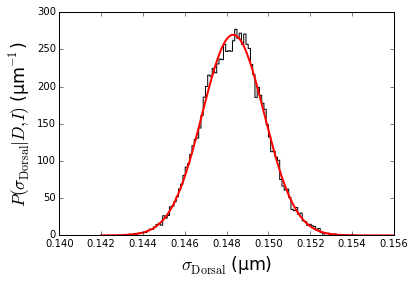

In [8]:
# Generate Gaussian for plotting
x = np.linspace(0.142, 0.156, 200)
mu = sampler.flatchain[:,0].mean()
sigma = sampler.flatchain[:,0].std()
p_gauss = np.exp(-(x - mu)**2 / 2.0 / sigma**2) / np.sqrt(2.0 * np.pi) \
        / sigma
    
# Plot histogram of marginalized posterior
n, b, p = plt.hist(sampler.flatchain[:,0],
                   bins=100, normed=True, histtype='step', color='k')
plt.plot(x, p_gauss, 'r-')
plt.xlabel(r'$\sigma_\mathrm{Dorsal}$ (µm)')
plt.ylabel(r'$P(\sigma_\mathrm{Dorsal}|D,I)$ (µm$^{-1}$)');

As a check, let's repeat the calculation for Venus.

In [9]:
# Set up the EnsembleSampler instance
sampler_venus = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior, 
                                args=(df.venus.dropna(), 0.0, 10.0))

# Do the burn-in
pos, prob, state = sampler_venus.run_mcmc(p0, n_burn, storechain=False)

# Reset sampler and run from the burn-in state we got to
sampler_venus.reset()
pos, prob, state = sampler_venus.run_mcmc(pos, n_steps)

We'll make the same comparisons.

In [55]:
# Mean and SEM from Gaussian likelihood
mean_gauss = df.venus.dropna().mean()
sem_gauss = df.venus.dropna().std() / len(df.venus.dropna())

# Mean and SEM from Cauchy likelihood (std calc. assumes approx. Gaussian)
mean_cauchy = sampler_venus.flatchain[:,0].mean()
sem_cauchy = sampler_venus.flatchain[:,0].std()

print("""
Gaussian likelihood: {0:.5f} +- {1:.5f}
Cauchy likelihood:   {2:.5f} +- {3:.5f}
""".format(mean_gauss, sem_gauss, mean_cauchy, sem_cauchy))


Gaussian likelihood: 0.17303 +- 0.00030
Cauchy likelihood:   0.17455 +- 0.00148



Again, we see that the "outliers" really did not have a strong effect on the mean.

To really see an effect, let's throw in a few outliers that are way out there.

In [ ]:
# Add outliers to the venus data
venus_corrupt = np.concatenate((df.venus.dropna().values, (0.45, 0.5, 0.46)))

# Look at beehive plot
bs_plot, ax = beeswarm.beeswarm([venus_corrupt], labels=['venus'])
plt.ylabel('gradient width')

# Print the mean
print('Mean with corrupt data: %.2f µm' % venus_corrupt.mean())

Now let's try to compute the mean with a Cauchy likelihood.

In [66]:
# Set up the EnsembleSampler instance
sampler_venus = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior, 
                                args=(df.venus.dropna(), 0.0, 10.0))

# Do the burn-in
pos, prob, state = sampler_venus.run_mcmc(p0, n_burn, storechain=False)

# Reset sampler and run from the burn-in state we got to
sampler_venus.reset()
pos, prob, state = sampler_venus.run_mcmc(pos, n_steps)

We'll compute the means and standard deviations for comparison, but note that the standard deviation for the Gaussian likelihood case has less meaning because of the outliers.

In [67]:
# Mean and SEM from Gaussian likelihood
mean_gauss = venus_corrupt.mean()
sem_gauss = venus_corrupt.std() / len(venus_corrupt)

# Mean and SEM from Cauchy likelihood (std calc. assumes approx. Gaussian)
mean_cauchy = sampler_venus.flatchain[:,0].mean()
sem_cauchy = sampler_venus.flatchain[:,0].std()

print("""
Gaussian likelihood: {0:.5f} +- {1:.5f}
Cauchy likelihood:   {2:.5f} +- {3:.5f}
""".format(mean_gauss, sem_gauss, mean_cauchy, sem_cauchy))


Gaussian likelihood: 0.20087 +- 0.00272
Cauchy likelihood:   0.17458 +- 0.00147



The mean was unswayed when we used the Cauchy distribution.  The posterior is still roughly Gaussian, which we'll verify below.  By choosing the Cauchy likelihood, we made ourselves more immune to outliers.

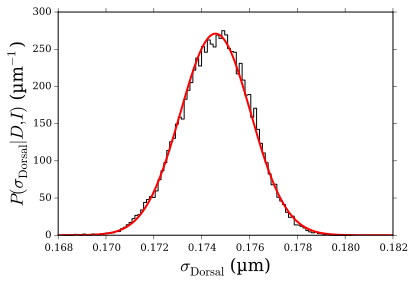

In [70]:
# Generate Gaussian for plotting
x = np.linspace(0.168, 0.182, 200)
mu = sampler_venus.flatchain[:,0].mean()
sigma = sampler_venus.flatchain[:,0].std()
p_gauss = np.exp(-(x - mu)**2 / 2.0 / sigma**2) / np.sqrt(2.0 * np.pi) \
        / sigma
    
# Plot histogram of marginalized posterior
n, b, p = plt.hist(sampler_venus.flatchain[:,0],
                   bins=100, normed=True, histtype='step', color='k')
plt.plot(x, p_gauss, 'r-')
plt.xlabel(r'$\sigma_\mathrm{Dorsal}$ (µm)')
plt.ylabel(r'$P(\sigma_\mathrm{Dorsal}|D,I)$ (µm$^{-1}$)')

### The Cauchy method for regressions

The simple parameter estimation with a Cauchy likelihood above might have been overkill.  We could have just used a robust statistic like the median to make ourselves immune from outliers.  Using the Cauchy likelihood becomes much more useful when we are performing a regression of a more complicated (even linear) function.

Data sets with strong outliers abound, but they are hard to come by.  Many times, researchers will just chuck the entire data set if it contains outliers and do the experiment again.  So, they are often hard to find in literature.  So, this is the only time in class when we will use a fabricated data set to learn a technique.

I prepared fake data with outliers, included in the file `linear_data_with_outliers.csv`.  You can get the file from the [Tutorial 5 data file](../protected/data/t5_data.zip).  Let's load them and plot them to see what we're dealing with.

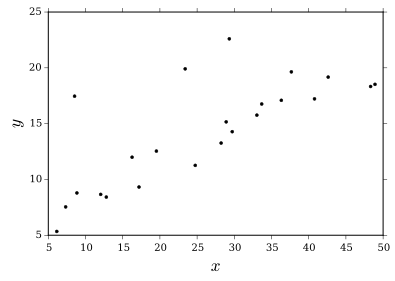

In [110]:
# Load data into DataFrame
df = pd.read_csv('linear_data_with_outliers.csv')

# Plot the data
plt.plot(df.x, df.y, 'k.')
plt.xlabel('$x$')
plt.ylabel('$y$');

Let's naively fit this with a line using `scipy.optimize.curve_fit`.

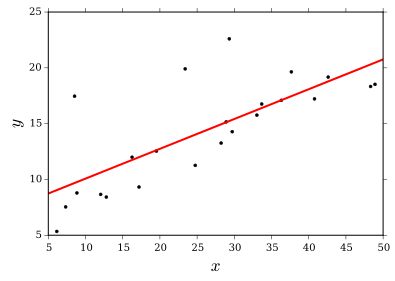

In [118]:
# Define linear fitting function
def linear_fun(x, a, b):
    """
    Linear function used with curve_fit
    """
    return a * x + b

# Initial guess and curve fit
p0 = np.array([0.5, 3.0])
popt, junk_output = scipy.optimize.curve_fit(linear_fun, df.x, df.y, p0)

# Make a smooth line
x_cf = np.array([5.0, 50.0])
y_cf = popt[0] * x_cf + popt[1]

# Plot results
plt.plot(df.x, df.y, 'k.')
plt.plot(x_cf, y_cf, 'r-')
plt.xlabel('$x$')
plt.ylabel('$y$');

The outliers seem to have tugged our line upward.  Let's do the regression using a Cauchy likelihood.  Now, our log posterior is

\begin{align}
\ln P(a, b, \beta~|~D,I) &= \text{constant} - (n+1) \ln \beta
- \sum_{i\in D} \ln\left(1 + \left(\frac{y_i - (a x_i + b)}{\beta}\right)^2\right) \\[1mm]
&\;\;\;\; - \frac{3}{2}\ln(1 + a^2),
\end{align}

where we have used the uninformative prior for linear regression.  We'll code up the posterior.

In [127]:
# Log posterior for linear function with Cauchy likelihood
def log_posterior_linear(p, x, y):
    """
    Log posterior.  
    
    x = x data
    y = y data
    
    p[0] = a (slope)
    p[1] = b (intercept)
    p[2] = beta (Cauchy scale parameter)
    """
    
    # Unpack parameters
    a, b, beta = p
    
    # Number of data
    n = len(x)
    
    if beta <= 0.0:
        return -np.inf
    else:
        return -1.5 * np.log(1.0 + a**2) - (n + 1) * np.log(beta) \
                  - np.log(1.0 + ((y - (a * x + b)) / beta)**2).sum()

And now let's run MCMC to get our best fit parameters.

In [128]:
# Set up MCMC parameters
n_dim = 3        # number of parameters in the model
n_walkers = 10   # number of MCMC walkers
n_burn = 500     # "burn-in" period to let chains stabilize
n_steps = 5000   # number of MCMC steps to take after burn-in

# Seed random number generator for reproducibility
np.random.seed(42)

# Generate random starting points for walkers.  
# p0[i,j] is the starting point for walk i along variable j.
p0 = np.empty((n_walkers, n_dim))
p0[:,0] = np.random.uniform(0.0, 5.0, n_walkers)     # slope
p0[:,1] = np.random.uniform(0.0, 20.0, n_walkers)   # intercept
p0[:,2] = np.random.exponential(1.0, n_walkers)      # beta

# Set up the EnsembleSampler instance
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior_linear, 
                                args=(df.x, df.y))

# Do the burn-in
pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)

# Reset sampler and run from the burn-in state we got to
sampler.reset()
pos, prob, state = sampler.run_mcmc(pos, n_steps)

Let's plot the result!

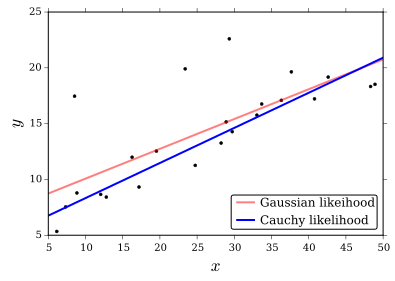

In [129]:
# Pull out most probable parameter values
max_ind = np.argmax(sampler.flatlnprobability)
a, b = sampler.flatchain[max_ind,:2]

# Plot results
# Make a smooth line
x_cauchy = np.array([5.0, 50.0])
y_cauchy = a * x_cauchy + b

# Plot results
plt.plot(df.x, df.y, 'k.')
plt.plot(x_cf, y_cf, 'r-', alpha=0.5, label='Gaussian likeihood')
plt.plot(x_cauchy, y_cauchy, 'b-', label='Cauchy likelihood')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend(loc='lower right')

Just because we can, let's make a corner plot to check out the parameter values.

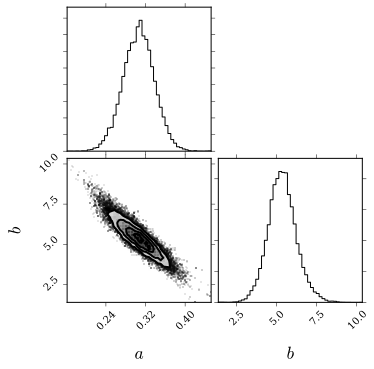

In [130]:
# Use triangle.corner to make summary plot
fig = triangle.corner(sampler.flatchain[:,:2], labels=[u'$a$', u'$b$'])

## The good-and-bad data method

This section is heavily based on [this superb blog post](http://jakevdp.github.io/blog/2014/06/06/frequentism-and-bayesianism-2-when-results-differ/) from Jake VanderPlas.

Let's assume for a moment that each datum can be good or bad.  We'll say that good data have an error bar of $\sigma$, and bad data have an error bar of $\sigma_\mathrm{bad}$.  Datum $i$ has a probability $g_i$ of being good.  Along with our mathematical model (linear functional relationship between $x$ and $y$), we have our model for the data and we can write the posterior.  We'll start by writing the likelihood.

\begin{align}
P(D~|~a, b, \sigma, \sigma_\mathrm{bad},\{g_i\}, I) &=
(2\pi)^{-n/2}\prod_{i\in D}\left(\begin{array}{l}
\;\;\;\;\frac{g_i}{\sigma}\exp\left\{-\frac{\left(y_i - (a x_i + b)\right)^2}{2\sigma^2}\right\} \\[1mm]
+ \frac{1-g_i}{\sigma_\mathrm{bad}}\exp\left\{-\frac{\left(y_i - (a x_i + b)\right)^2}{2\sigma_\mathrm{bad}^2}\right\}
\end{array}
\right)
\end{align}

\begin{align}
\ln P(a,b,\sigma, \sigma_\mathrm{bad},\{g_i\}~|~D,I) &= \text{constant}
-\frac{3}{2}\ln (1 + a^2) - \ln\sigma - \ln \sigma_\mathrm{bad}\\[1mm]
&\;\;\;\;- \sum_{i\in D}\ln \left(\begin{array}{l}
\;\;\;\;\frac{g_i}{\sigma}\exp\left\{-\frac{\left(y_i - (a x_i + b)\right)^2}{2\sigma^2}\right\} \\[1mm]
+ \frac{1-g_i}{\sigma_\mathrm{bad}}\exp\left\{-\frac{\left(y_i - (a x_i + b)\right)^2}{2\sigma_\mathrm{bad}^2}\right\}
\end{array}
\right).
\end{align}

We note that the fact that $0\le g_i\le 1$ is encoded in the priors for $g_i$ and that $\sigma_\mathrm{bad} > \sigma$ is encoded in the prior for $\sigma$ and $\sigma_\mathrm{bad}$.

When we code up the log posterior, we need to be careful of numerical precision issues when computing the sum of the exponentials.  It is better to take the logs of the exponentials and then  use NumPy's `logaddexp` to do take the log of the sum of the exponentials.

In [160]:
def log_posterior_good_bad(p, x, y):
    """
    """
    # Pull out parameters
    a, b, sigma, sigma_bad = p[:4]
    g = p[4:]
    
    # Check to make sure the prior conditions are ok
    if (g < 0.0).any() or (g > 1.0).any() or sigma <= 0.0 \
            or sigma_bad < sigma:
        return -np.inf
    
    # log prior
    log_prior = -1.5 * np.log(1.0 + a**2) - np.log(sigma) - np.log(sigma_bad)
    
    # Add in likelihood
    log_like_good = np.log(g / sigma) - ((y - (a * x + b)) / sigma)**2 / 2.0
    log_like_bad = np.log((1.0 - g) / sigma_bad) \
                        - ((y - (a * x + b)) / sigma_bad)**2 / 2.0
    log_like = np.logaddexp(log_like_good, log_like_bad).sum()
    
    # Return the whole posterior
    return log_prior + log_like

Now that we have our log posterior, we can run MCMC.

In [191]:
# Set up MCMC parameters
n_dim = 4 + len(df.x)         # number of parameters in the model
n_walkers = 100               # number of MCMC walkers
n_burn = 20000                 # "burn-in" period to let chains stabilize
n_steps = 100000               # number of MCMC steps to take after burn-in

# Seed random number generator for reproducibility
np.random.seed(42)

# Generate random starting points for walkers.  
# p0[i,j] is the starting point for walk i along variable j.
p0 = np.empty((n_walkers, n_dim))
p0[:,0] = np.random.uniform(0.0, 5.0, n_walkers)     # slope
p0[:,1] = np.random.uniform(0.0, 20.0, n_walkers)   # intercept
p0[:,2] = np.random.exponential(1.0, n_walkers)      # sigma
p0[:,3] = np.random.exponential(10.0, n_walkers)      # sigma_bad
p0[:,4:] = np.random.uniform(0.0, 1.0, (n_walkers, n_dim-4)) # g_i

# Set up the EnsembleSampler instance
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior_good_bad, 
                                args=(df.x, df.y))

# Do the burn-in
pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)

# Reset sampler and run from the burn-in state we got to
sampler.reset()
pos, prob, state = sampler.run_mcmc(pos, n_steps)

After that long MCMC calculation, let's see what we have.

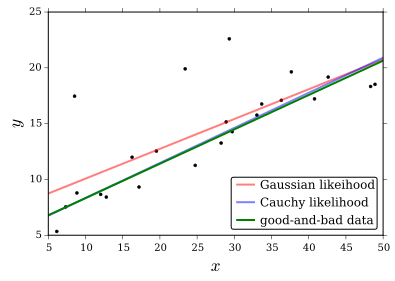

In [199]:
# Get most probable parameters
max_ind = np.argmax(sampler.flatlnprobability)
a_goodbad, b_goodbad = sampler.flatchain[max_ind,:2]

# Plot results
# Make a smooth line
x_goodbad = np.array([5.0, 50.0])
y_goodbad = a_goodbad * x_goodbad + b_goodbad

# Plot results
plt.plot(df.x, df.y, 'k.')
plt.plot(x_cf, y_cf, 'r-', alpha=0.5, label='Gaussian likeihood')
plt.plot(x_cauchy, y_cauchy, 'b-', alpha=0.5, label='Cauchy likelihood')
plt.plot(x_goodbad, y_goodbad, 'g-', label='good-and-bad data')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend(loc='lower right');

We have achieved almost the same results as the Cauchy likelihood.  Let's look at the posterior.

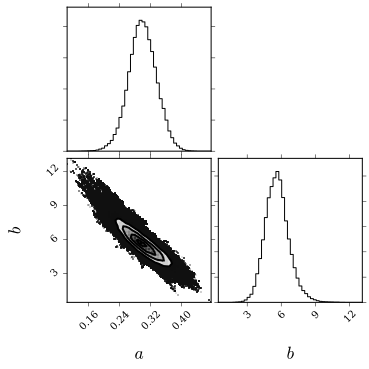

In [200]:
# Use triangle.corner to make summary plot
fig = triangle.corner(sampler.flatchain[:,:2], labels=[u'$a$', u'$b$'])

We see a bit of a longer tail on the intercept $b$, but very close to the same result as with the Cauchy likelihood.

With the good-bad-data model, we can actually identify the good and bad data.  Let $\bar{g}$ be the average goodness of data and $\sigma_g$ to be the standard deviation of goodness of data across all data points.  Then, we'll denote a bad data point to be one where $g_i < \bar{g} - 2\sigma_g$.

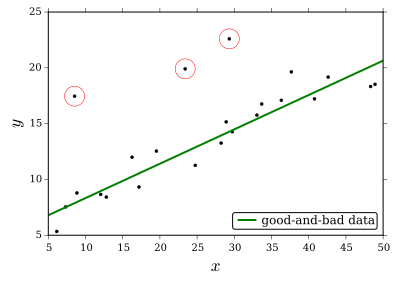

In [230]:
# Compute mean goodness of data
g = sampler.flatchain[:,4:].mean(axis=0)
outliers = (g < g.mean() - 2*g.std())

# Plot results with outliers circled
# Plot results
plt.plot(df.x, df.y, 'k.')
plt.plot(df.x[outliers], df.y[outliers], 'ro', ms=20, mfc='none', mec='red')
plt.plot(x_goodbad, y_goodbad, 'g-', label='good-and-bad data')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend(loc='lower right');

Note that these data were still included in our regression.  Their weight was mitigated by having a larger standard deviation describing the spread in the data from the mathematical model.  Finally, we can look at what our $\sigma$'s were for the good and bad data.

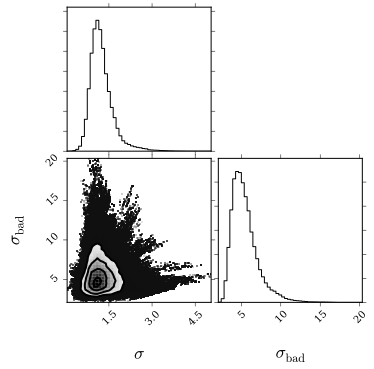

In [231]:
# Make triangle plot for sigma values
fig = triangle.corner(sampler.flatchain[:,2:4], 
                      labels=[r'$\sigma$', r'$\sigma_\mathrm{bad}$'])

In [1]:
n, b, p = plt.hist(sampler.flatchain[:,4], normed=True, histstyle='step',
                   bins=100, color='k')

NameError: name 'plt' is not defined